In [1]:
import pandas as pd
import numpy as np
import re
import string

# import warnings
# warnings.filterwarnings("ignore", category=DeprecationWarning)

### Definiciones

In [36]:
meses = ['202112','202201','202202','202203','202204']   # Meses a analizar
seccion = 'politica'   # Sección para filtrar, si queda en blanco se usan todas las noticias
objeto = 3   # 1 solo titulos 2 solo cuerpo 3 ambos (default)

### Descarga y lectura del dataset

In [37]:
# Leemos todos los csvs mensuaes
# Integramos todo en un único DataFrame

files = {}

for m in meses:
    url = 'https://github.com/fermasia/news-base/blob/main/files/' + m + '.csv.gz?raw=true'
    files[m] = pd.read_csv(url, compression='gzip')
    
df = pd.concat(files.values(), ignore_index=True)

#del files

In [38]:
for m in meses:
    print(m,len(files[m].link))

202112 25090
202201 30363
202202 23109
202203 18172
202204 3267


### Vamos a construir un campo que tenga el dato de AAAAMM (YYYYMM)
##### Para agrupar luego por medio y por mes-año

In [39]:
df['date'] = pd.to_datetime(df['date'], errors='coerce', utc=True)
df['yyyymm'] = df['date'].dt.year.astype(str) + '-' + df['date'].dt.month.astype(str)

##### Aprovechamos a ordenar las filas por medio y AAAAMM y reseteamos los índices para luego poder joinear

In [40]:
df.sort_values(by=['yyyymm','source'],ascending=True,inplace=True)
df.reset_index(drop=True,inplace=True) 

### Crear el corpus filtrando por sección

In [41]:
if seccion == '':
    corpus_df = df
else:
    corpus_df = df[df.category == seccion]
    
corpus_df['source'] = corpus_df['yyyymm'] + '_' + corpus_df['source']
sources_df = corpus_df['source'] # conservamos los origenes y el mes año para unir luego de procesar

if  objeto == 1:
    corpus_df = pd.DataFrame(corpus_df.title)
    col = 'title'

elif objeto == 2:
    corpus_df = pd.DataFrame(corpus_df.text)
    col = 'text'
else:
    corpus_df = pd.DataFrame(corpus_df.title + ' ' + corpus_df.text)
    col = 0

corpus_df.rename(columns={col:'text'},inplace=True)
corpus_df['text'] = corpus_df.text.astype(str)
corpus_bert = corpus_df['text'].copy()

/tmp/ipykernel_148/2066408061.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corpus_df['source'] = corpus_df['yyyymm'] + '_' + corpus_df['source']


In [42]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?¿\]\%;,"“”', ' ', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\w*\d\w*', '', text)
    text = text.replace('\xa0',' ')
    text = re.sub('[‘’“”…«»]', '', text)
    text = re.sub('\n', ' ', text)
    text = text.replace('?',' ')
    text = text.replace('¿',' ')
    # Eliminamos los caracteres especiales
    text = re.sub(r'\W', ' ', str(text))
    # Eliminado las palabras que tengo un solo caracter
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    # Sustituir los espacios en blanco en uno solo
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    return text

corpus_df['text'] = corpus_df.text.apply(clean_text)

In [43]:
stopwords_es = pd.read_csv('https://raw.githubusercontent.com/jbagnato/machine-learning/master/nlp/spanish.txt',header=None)[0].to_list()
aditional_sw = ['ciento','gobierno','argentina','window','t','terminación','año','si','no','dijo','país','política','años','año']
stopwords_es = stopwords_es + aditional_sw 

def remove_stopwords(text):
    stripped_text = [w for w in text.split() if w not in stopwords_es and not w.isdigit()]
    return ' '.join(word for word in stripped_text)

def remove_word(text,word='terminación'):
    stripped_text = [w for w in text.split() if word not in w]
    return ' '.join(word for word in stripped_text)

corpus_df.text = corpus_df.text.apply(remove_stopwords)
corpus_df.text = corpus_df.text.apply(remove_word)

In [44]:
complete_df = pd.merge(corpus_df, sources_df, left_index=True, right_index=True)

## Vamos a hacer WordClouds por mes y por medio

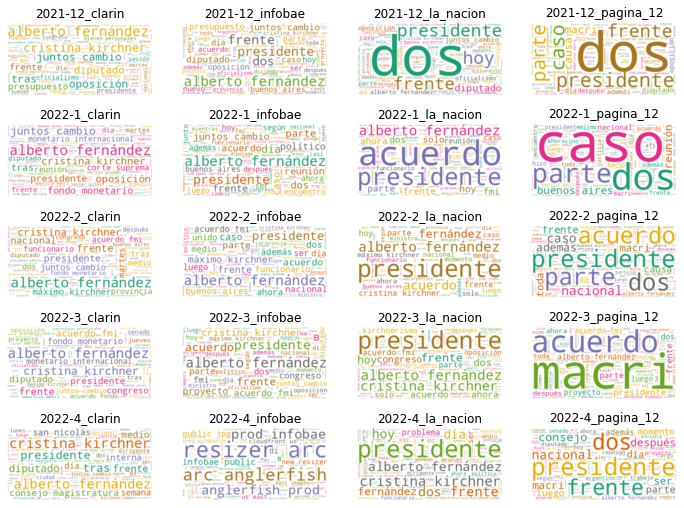

In [45]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def crear_wordclouds(df):
    wc = WordCloud(background_color="white", colormap="Dark2",
                   max_font_size=150, random_state=42)

    plt.rcParams['figure.figsize'] = [12,9]

    sources = complete_df.source.unique().tolist()

    index = 0

    width = 4
    height = int(np.round(len(complete_df.source.unique()) / width,0))

    for source in sources:
        index += 1
        bag = df.text[df.source == source].str.cat(sep=' ')
        wc.generate(bag)
        plt.subplot(height, width, index)
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.title(source)

    plt.show()
    
crear_wordclouds(complete_df)

# Detección de Tópicos

In [46]:
import json, re
import pandas as pd 
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import ToktokTokenizer

In [47]:
tokenizer = ToktokTokenizer() 
corpus_df["Tokens"] = corpus_df.text.apply(tokenizer.tokenize)
corpus_df.head()

,text,Tokens
35,juan manzur wado pedro cabecera mesa rosada co...,"[juan, manzur, wado, pedro, cabecera, mesa, ro..."
36,video piñas empujones elección presidencia juv...,"[video, piñas, empujones, elección, presidenci..."
37,derrota grande difícil imaginar derrota grande...,"[derrota, grande, difícil, imaginar, derrota, ..."
38,agustín rossi pasó peronismo ex ministro defen...,"[agustín, rossi, pasó, peronismo, ex, ministro..."
39,debilidades crecieron últimamente esteban bull...,"[debilidades, crecieron, últimamente, esteban,..."


In [48]:
stemmer = SnowballStemmer("spanish")

def stem_palabras(tokens):
    """
    Reduce cada palabra de una lista dada a su raíz.
    """
    return [stemmer.stem(token) for token in tokens]

corpus_df["Stems"] = corpus_df.Tokens.apply(stem_palabras)

corpus_df.head()

,text,Tokens,Stems
35,juan manzur wado pedro cabecera mesa rosada co...,"[juan, manzur, wado, pedro, cabecera, mesa, ro...","[juan, manzur, wad, pedr, cabecer, mes, ros, c..."
36,video piñas empujones elección presidencia juv...,"[video, piñas, empujones, elección, presidenci...","[vide, piñ, empujon, eleccion, president, juve..."
37,derrota grande difícil imaginar derrota grande...,"[derrota, grande, difícil, imaginar, derrota, ...","[derrot, grand, dificil, imagin, derrot, grand..."
38,agustín rossi pasó peronismo ex ministro defen...,"[agustín, rossi, pasó, peronismo, ex, ministro...","[agustin, rossi, pas, peron, ex, ministr, defe..."
39,debilidades crecieron últimamente esteban bull...,"[debilidades, crecieron, últimamente, esteban,...","[debil, crec, ultim, esteb, bullrich, acto, pr..."


In [49]:
from gensim.corpora import Dictionary
from gensim.models import LdaModel
import random
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
%matplotlib inline

In [50]:
diccionario = Dictionary(corpus_df.Stems)
print(f'Número de tokens: {len(diccionario)}')

diccionario.filter_extremes(no_below=2, no_above = 0.8)
print(f'Número de tokens limpiando palabras por frecuencia: {len(diccionario)}')

Número de tokens: 51575
Número de tokens limpiando palabras por frecuencia: 23656


In [51]:
# Creamos el corpus 
corpus = [diccionario.doc2bow(noticia) for noticia in corpus_df.Stems]

# Mostramos el BOW de una noticia
print(corpus[6])

[(18, 1), (36, 1), (50, 1), (55, 1), (56, 1), (59, 2), (112, 1), (116, 1), (144, 1), (164, 1), (176, 1), (177, 1), (178, 1), (179, 1), (180, 1), (181, 2), (182, 1), (183, 1), (184, 1), (185, 1), (186, 1), (187, 1), (188, 1), (189, 1), (190, 1), (191, 1), (192, 1), (193, 1), (194, 1), (195, 1), (196, 1), (197, 1), (198, 1), (199, 1), (200, 1), (201, 1), (202, 1), (203, 1), (204, 1), (205, 1), (206, 1), (207, 1), (208, 1), (209, 1)]


In [52]:
topics = 30
lda = LdaModel(corpus=corpus, id2word=diccionario, 
               num_topics=topics, random_state=42, 
               chunksize=1000, passes=10, alpha='auto')

In [53]:
topicos = lda.print_topics(num_words=5, num_topics=topics)
for topico in topicos:
    print(topico)

(0, '0.098*"cristin" + 0.086*"kirchn" + 0.034*"vicepresident" + 0.029*"fernandez" + 0.023*"president"')
(1, '0.034*"kirchn" + 0.029*"president" + 0.028*"fernandez" + 0.026*"campor" + 0.025*"maxim"')
(2, '0.021*"trabaj" + 0.016*"educ" + 0.010*"escuel" + 0.009*"gener" + 0.008*"estudi"')
(3, '0.019*"facult" + 0.017*"accion" + 0.015*"estudi" + 0.014*"mitr" + 0.012*"nuev"')
(4, '0.018*"unid" + 0.018*"rusi" + 0.016*"ucrani" + 0.016*"president" + 0.015*"fernandez"')
(5, '0.034*"malvin" + 0.019*"islas" + 0.019*"incendi" + 0.019*"soberan" + 0.018*"argentin"')
(6, '0.020*"afi" + 0.013*"inteligent" + 0.011*"sindical" + 0.011*"moyan" + 0.010*"judicial"')
(7, '0.039*"radical" + 0.026*"negri" + 0.023*"ucr" + 0.022*"diput" + 0.019*"mari"')
(8, '0.039*"plaz" + 0.039*"memori" + 0.037*"derech" + 0.035*"human" + 0.035*"may"')
(9, '0.014*"nacional" + 0.009*"part" + 0.008*"trabaj" + 0.008*"public" + 0.007*"tom"')
(10, '0.018*"hac" + 0.009*"habl" + 0.009*"ser" + 0.009*"pas" + 0.007*"pued"')
(11, '0.024*"deu

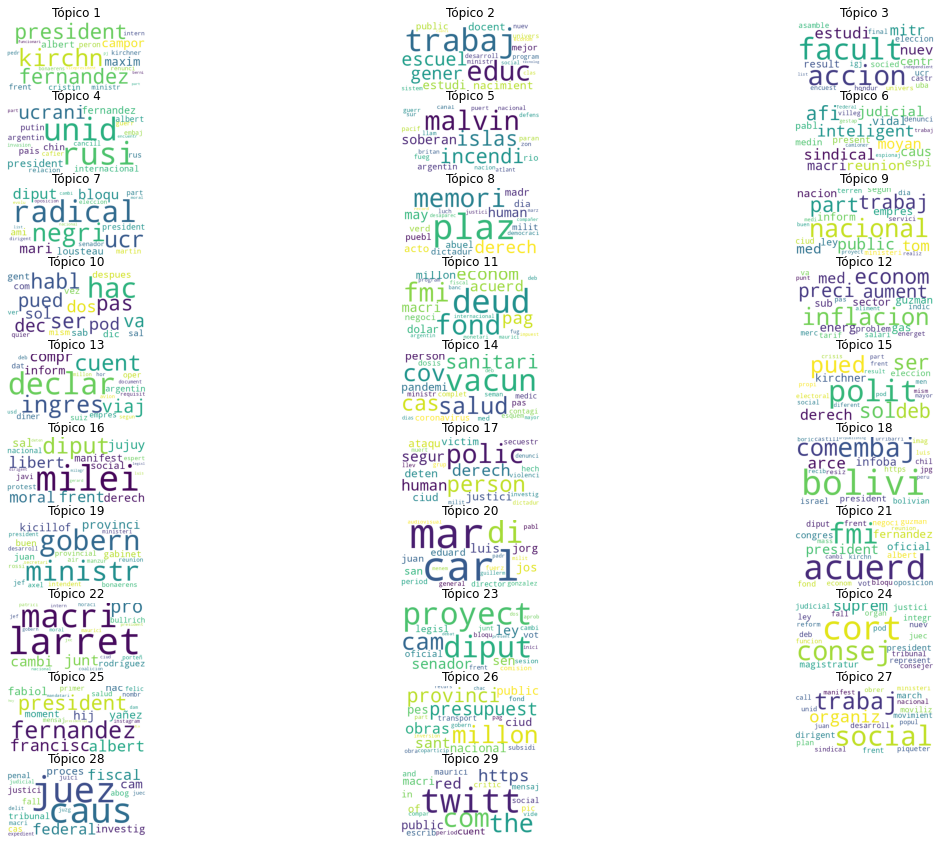

In [55]:
cant_topicos = topics
columnas = 3
if (cant_topicos % columnas) > 0:
    filas = int(cant_topicos/columnas) + 1
else:
    filas = int(cant_topicos/columnas)

for i in range(1, cant_topicos):
    plt.subplot(filas,columnas,i)
    plt.rcParams['figure.figsize'] = [40,15]
#     plt.figure()
    plt.imshow(WordCloud(background_color='white', prefer_horizontal=1.0)
               .fit_words(dict(lda.show_topic(i, 20))))
    plt.axis("off")
    plt.title("Tópico " + str(i))
plt.show()

### Try BERT

In [56]:
from bertopic import BERTopic

In [57]:
#topic_model = BERTopic(language="spanish", calculate_probabilities=True, verbose=True)
topic_model = BERTopic(verbose=True,embedding_model='paraphrase-MiniLM-L3-v2', min_topic_size= 7)
topics, probs = topic_model.fit_transform(corpus_bert.to_list())

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.69k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/69.6M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/314 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Batches:   0%|          | 0/254 [00:00<?, ?it/s]

2022-04-12 20:09:53,329 - BERTopic - Transformed documents to Embeddings
2022-04-12 20:10:22,126 - BERTopic - Reduced dimensionality with UMAP
2022-04-12 20:10:23,101 - BERTopic - Clustered UMAP embeddings with HDBSCAN


In [60]:
freq = topic_model.get_topic_info()
print("Number of topics: {}".format( len(freq)))
freq.head(25)

Number of topics: 156


,Topic,Count,Name
0,-1,2983,-1_de_la_que_el
1,0,376,0_acuerdo_fmi_el_con
2,1,229,1_política_ha_en_las
3,2,199,2_larreta_rodríguez_horacio_porteño
4,3,165,3_consejo_magistratura_corte_abogados
5,4,158,4_afi_villegas_gestapo_vidal
6,5,143,5_ucrania_rusia_invasión_putin
7,6,104,6_las_gobierno_de_la
8,7,103,7_juntos_cambio_por_bienes
9,8,91,8_macri_mauricio_expresidente_que


In [ ]:
freq = topic_model.get_topic_info(); freq.head(10)

In [ ]:
topic_model.visualize_topics()

In [ ]:
new_topics, new_probs = topic_model.reduce_topics(corpus_bert.to_list(), topics, probs, nr_topics=20)

In [ ]:
topic_model.visualize_topics()

In [ ]:
topic_model.visualize_distribution(probs[200], min_probability=0.001)

In [ ]:
topic_model.visualize_hierarchy(top_n_topics=50)

In [ ]:
topic_model.visualize_barchart(top_n_topics=5)

In [ ]:
topic_model.visualize_heatmap(n_clusters=20, width=1000, height=1000)